In [2]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from sklearn.cluster import MiniBatchKMeans, KMeans
import setGPU
import numpy as np

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import setGPU

In [3]:
use_cuda = torch.cuda.is_available()
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
#trans = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)
batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [26]:
import time
timingResult = {}
def logTime(theName, currentTime):
    if theName not in timingResult:
        timingResult[theName] = time.time() - currentTime
    else:
        timingResult[theName] = timingResult[theName] + (time.time() - currentTime)
    currentTime = time.time()
    return currentTime

def printTiming(name):
    print('======== timing for {}: {} ======='.format(name,timingResult[name]))

In [27]:
class DEC_AE(nn.Module):
    def __init__(self, num_classes, num_features):
        super(DEC_AE,self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(28*28,500)
        self.fc2 = nn.Linear(500,500)
        self.fc3 = nn.Linear(500,2000)
        self.fc4 = nn.Linear(2000,num_features)
        self.relu = nn.ReLU()
        self.fc_d1 = nn.Linear(500,28*28)
        self.fc_d2 = nn.Linear(500,500)
        self.fc_d3 = nn.Linear(2000,500)
        self.fc_d4 = nn.Linear(num_features,2000)
        self.alpha = 1.0
        self.clusterCenter = nn.Parameter(torch.zeros(num_classes,num_features))
        self.pretrainMode = True
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform(m.weight)

    def setPretrain(self,mode):
        """To set training mode to pretrain or not, 
        so that it can control to run only the Encoder or Encoder+Decoder"""
        self.pretrainMode = mode
    def updateClusterCenter(self, cc):
        """
        To update the cluster center. This is a method for pre-train phase.
        When a center is being provided by kmeans, we need to update it so
        that it is available for further training
        :param cc: the cluster centers to update, size of num_classes x num_features
        """
        self.clusterCenter.data = torch.from_numpy(cc)
    def getTDistribution(self,x, clusterCenter):
        """
        student t-distribution, as same as used in t-SNE algorithm.
         q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
         
         :param x: input data, in this context it is encoder output
         :param clusterCenter: the cluster center from kmeans
         """
        xe = torch.unsqueeze(x,1).cuda() - clusterCenter.cuda()
        q = 1.0 / (1.0 + (torch.sum(torch.mul(xe,xe), 2) / self.alpha))
        q = q ** (self.alpha + 1.0) / 2.0
        q = (q.t() / torch.sum(q, 1)).t() #due to divison, we need to transpose q
        return q
        
    def forward(self,x):
        x = x.view(-1, 1*28*28)
        # 32x32x1
        x = self.dropout(x)
        # 32x32x1
        x = self.fc1(x)
        # 17x17x50
        x = self.relu(x)
        # 17x17x50
        x = self.fc2(x)
        # 17x17x50
        x = self.relu(x)
        # 9x9x50
        x = self.fc3(x)
        # 17x17x50
        x = self.relu(x)
        x = self.fc4(x)
        # 9x9x50
        x_ae = x
        #if not in pretrain mode, we only need encoder
        if self.pretrainMode == False:
            return x, self.getTDistribution(x,self.clusterCenter)
        # 1x68
        ##### encoder is done, followed by decoder #####
        # 1x68
        x = self.fc_d4(x)
        # 1x4050
        x = self.relu(x)
        # 1x4050
        x = self.fc_d3(x)
        # 1x4050
        x = self.relu(x)
        x = self.fc_d2(x)
        # 1x4050
        x = self.relu(x)
        x = self.fc_d1(x)
        x_de = x.view(-1,1,28,28)
        # 1x4050
        return x_ae, x_de

In [28]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [29]:
class DEC:
    """The class for controlling the training process of DEC"""
    def __init__(self,n_clusters,alpha=1.0):
        self.n_clusters=n_clusters
        self.alpha = alpha
        
    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        #print('q',q)
        return Variable((weight.t() / weight.sum(1)).t().data, requires_grad=True)
    def logAccuracy(self,pred,label):
        print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
          % (acc(label, pred), nmi(label, pred)))
    @staticmethod
    def kld(q,p):
        res = torch.sum(p*torch.log(p/q),dim=-1)
        return res
    
    def validateOnCompleteTestData(self,test_loader,model):
        model.eval()
        to_eval = np.array([model(d[0].cuda())[0].data.cpu().numpy() for i,d in enumerate(test_loader)])
        true_labels = np.array([d[1].cpu().numpy() for i,d in enumerate(test_loader)])
        to_eval = np.reshape(to_eval,(to_eval.shape[0]*to_eval.shape[1],to_eval.shape[2]))
        true_labels = np.reshape(true_labels,true_labels.shape[0]*true_labels.shape[1])
        km = KMeans(n_clusters=len(np.unique(true_labels)), n_init=20, n_jobs=4)
        y_pred = km.fit_predict(to_eval)
        print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                      % (acc(true_labels, y_pred), nmi(true_labels, y_pred)))
        currentAcc = acc(true_labels, y_pred)
        return currentAcc
    
    def pretrain(self,train_loader, test_loader, epochs):
        dec_ae = DEC_AE(10,10).cuda() #auto encoder
        mseloss = nn.MSELoss()
        optimizer = optim.SGD(dec_ae.parameters(),lr = 1, momentum=0.9)
        best_acc = 0.0
        for epoch in range(epochs):
            dec_ae.train()
            running_loss=0.0
            for i,data in enumerate(train_loader):
                x, label = data
                x, label = Variable(x).cuda(),Variable(label).cuda()
                optimizer.zero_grad()
                x_ae,x_de = dec_ae(x)
                loss = F.mse_loss(x_de,x,reduce=True) 
                loss.backward()
                optimizer.step()
                x_eval = x.data.cpu().numpy()
                label_eval = label.data.cpu().numpy()
                running_loss += loss.data.cpu().numpy()
                if i % 100 == 99:    # print every 100 mini-batches
                    print('[%d, %5d] loss: %.7f' %
                          (epoch + 1, i + 1, running_loss / 100))
                    running_loss = 0.0
            #now we evaluate the accuracy with AE
            dec_ae.eval()
            currentAcc = self.validateOnCompleteTestData(test_loader,dec_ae)
            if currentAcc > best_acc:                
                torch.save(dec_ae,'bestModel'.format(best_acc))
                best_acc = currentAcc
    def clustering(self,mbk,x,model):
        model.eval()
        y_pred_ae,_ = model(x)
        y_pred_ae = y_pred_ae.data.cpu().numpy()
        y_pred = mbk.partial_fit(y_pred_ae) #seems we can only get a centre from batch
        self.cluster_centers = mbk.cluster_centers_ #keep the cluster centers
        model.updateClusterCenter(self.cluster_centers)
    def train(self,train_loader, test_loader, epochs):
        """This method will start training for DEC cluster"""
        ct = time.time()
        model = torch.load("bestModel").cuda()
        model.setPretrain(False)
        optimizer = optim.SGD([\
             {'params': model.parameters()}, \
            ],lr = 0.01, momentum=0.9)
        print('Initializing cluster center with pre-trained weights')
        mbk = MiniBatchKMeans(n_clusters=self.n_clusters, n_init=20, batch_size=batch_size)
        got_cluster_center = False
        for epoch in range(epochs):
            for i,data in enumerate(train_loader):
                x, label = data
                x = Variable(x).cuda()
                optimizer.zero_grad()
                #step 1 - get cluster center from batch
                #here we are using minibatch kmeans to be able to cope with larger dataset.
                if not got_cluster_center:
                    self.clustering(mbk,x,model)
                    if epoch > 1:
                        got_cluster_center = True
                else:
                    model.train()
                    #now we start training with acquired cluster center
                    feature_pred,q = model(x)
                    #get target distribution
                    p = self.target_distribution(q)
                    #print('q',q,'p',p)
                    loss = self.kld(q,p).mean()
                    loss.backward()
                    optimizer.step()
            currentAcc = self.validateOnCompleteTestData(test_loader,model)


In [55]:
#now start training
import random
random.seed(7)
dec = DEC(10)
dec.pretrain(train_loader, test_loader, 200)
#dec.train(train_loader, test_loader, 200)

/tmp/nchernya/ipykernel_12315/4094639439.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[1,   100] loss: 0.0775370
[1,   200] loss: 0.0590238
[1,   300] loss: 0.0488194
[1,   400] loss: 0.0411578
[1,   500] loss: 0.0367771
[1,   600] loss: 0.0343443


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5169,  nmi: 0.4752  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[2,   100] loss: 0.0324259
[2,   200] loss: 0.0311707
[2,   300] loss: 0.0297680
[2,   400] loss: 0.0287924
[2,   500] loss: 0.0280225
[2,   600] loss: 0.0273708


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.5526,  nmi: 0.5188  <==|
[3,   100] loss: 0.0264385
[3,   200] loss: 0.0260368
[3,   300] loss: 0.0255995
[3,   400] loss: 0.0252040
[3,   500] loss: 0.0248253
[3,   600] loss: 0.0244198


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.5893,  nmi: 0.5533  <==|
[4,   100] loss: 0.0239856
[4,   200] loss: 0.0237667
[4,   300] loss: 0.0233705
[4,   400] loss: 0.0231936
[4,   500] loss: 0.0227747
[4,   600] loss: 0.0229103


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5974,  nmi: 0.5542  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[5,   100] loss: 0.0225100
[5,   200] loss: 0.0220785
[5,   300] loss: 0.0220677
[5,   400] loss: 0.0219189
[5,   500] loss: 0.0216708
[5,   600] loss: 0.0215807


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6085,  nmi: 0.5667  <==|
[6,   100] loss: 0.0213292
[6,   200] loss: 0.0211217
[6,   300] loss: 0.0210360
[6,   400] loss: 0.0208116
[6,   500] loss: 0.0207087
[6,   600] loss: 0.0205925


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6090,  nmi: 0.5669  <==|
[7,   100] loss: 0.0202894
[7,   200] loss: 0.0202298
[7,   300] loss: 0.0203475
[7,   400] loss: 0.0199883
[7,   500] loss: 0.0200148
[7,   600] loss: 0.0198527


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 a

        |==>  acc: 0.6216,  nmi: 0.5831  <==|
[8,   100] loss: 0.0195142
[8,   200] loss: 0.0195800
[8,   300] loss: 0.0195542
[8,   400] loss: 0.0194860
[8,   500] loss: 0.0193921
[8,   600] loss: 0.0192821


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6308,  nmi: 0.5948  <==|
[9,   100] loss: 0.0190112
[9,   200] loss: 0.0191651
[9,   300] loss: 0.0190007
[9,   400] loss: 0.0188525
[9,   500] loss: 0.0187271
[9,   600] loss: 0.0187845


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6329,  nmi: 0.5976  <==|
[10,   100] loss: 0.0185224
[10,   200] loss: 0.0185023
[10,   300] loss: 0.0183676
[10,   400] loss: 0.0186608
[10,   500] loss: 0.0183813
[10,   600] loss: 0.0183504


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6438,  nmi: 0.6053  <==|
[11,   100] loss: 0.0180833
[11,   200] loss: 0.0182321
[11,   300] loss: 0.0180614
[11,   400] loss: 0.0180616
[11,   500] loss: 0.0179312
[11,   600] loss: 0.0179060


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6477,  nmi: 0.6142  <==|
[12,   100] loss: 0.0176956
[12,   200] loss: 0.0177889
[12,   300] loss: 0.0178118
[12,   400] loss: 0.0175665
[12,   500] loss: 0.0175523
[12,   600] loss: 0.0175245


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6607,  nmi: 0.6228  <==|
[13,   100] loss: 0.0174211
[13,   200] loss: 0.0174770
[13,   300] loss: 0.0173853
[13,   400] loss: 0.0173676
[13,   500] loss: 0.0173313
[13,   600] loss: 0.0171852


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6614,  nmi: 0.6229  <==|
[14,   100] loss: 0.0169837
[14,   200] loss: 0.0170615
[14,   300] loss: 0.0171670
[14,   400] loss: 0.0169284
[14,   500] loss: 0.0170960
[14,   600] loss: 0.0170780


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6625,  nmi: 0.6267  <==|
[15,   100] loss: 0.0168412
[15,   200] loss: 0.0166883
[15,   300] loss: 0.0168774
[15,   400] loss: 0.0167823
[15,   500] loss: 0.0167050
[15,   600] loss: 0.0168169


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6726,  nmi: 0.6323  <==|
[16,   100] loss: 0.0164963
[16,   200] loss: 0.0167280
[16,   300] loss: 0.0165481
[16,   400] loss: 0.0165227
[16,   500] loss: 0.0165626
[16,   600] loss: 0.0163581


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6843,  nmi: 0.6417  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[17,   100] loss: 0.0163341
[17,   200] loss: 0.0164793
[17,   300] loss: 0.0162207
[17,   400] loss: 0.0161844
[17,   500] loss: 0.0163712
[17,   600] loss: 0.0162611


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6736,  nmi: 0.6373  <==|
[18,   100] loss: 0.0161617
[18,   200] loss: 0.0160337
[18,   300] loss: 0.0162503
[18,   400] loss: 0.0160045
[18,   500] loss: 0.0161627
[18,   600] loss: 0.0159430


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6860,  nmi: 0.6436  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[19,   100] loss: 0.0159628
[19,   200] loss: 0.0158429
[19,   300] loss: 0.0159554
[19,   400] loss: 0.0159137
[19,   500] loss: 0.0158362
[19,   600] loss: 0.0158977


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6820,  nmi: 0.6416  <==|
[20,   100] loss: 0.0156925
[20,   200] loss: 0.0157732
[20,   300] loss: 0.0157855
[20,   400] loss: 0.0155305
[20,   500] loss: 0.0156706
[20,   600] loss: 0.0158350


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6865,  nmi: 0.6488  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[21,   100] loss: 0.0155059
[21,   200] loss: 0.0153861
[21,   300] loss: 0.0155910
[21,   400] loss: 0.0156486
[21,   500] loss: 0.0156448
[21,   600] loss: 0.0154364


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6888,  nmi: 0.6513  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[22,   100] loss: 0.0152580
[22,   200] loss: 0.0152571
[22,   300] loss: 0.0154571
[22,   400] loss: 0.0152232
[22,   500] loss: 0.0155059
[22,   600] loss: 0.0154346


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7177,  nmi: 0.6727  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[23,   100] loss: 0.0151361
[23,   200] loss: 0.0151422
[23,   300] loss: 0.0151463
[23,   400] loss: 0.0152074
[23,   500] loss: 0.0152847
[23,   600] loss: 0.0153240


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.6982,  nmi: 0.6598  <==|
[24,   100] loss: 0.0148956
[24,   200] loss: 0.0150568
[24,   300] loss: 0.0151995
[24,   400] loss: 0.0150075
[24,   500] loss: 0.0151421
[24,   600] loss: 0.0150696


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7163,  nmi: 0.6730  <==|
[25,   100] loss: 0.0149700
[25,   200] loss: 0.0149048
[25,   300] loss: 0.0149015
[25,   400] loss: 0.0150346
[25,   500] loss: 0.0148960
[25,   600] loss: 0.0148370


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7052,  nmi: 0.6700  <==|
[26,   100] loss: 0.0147253
[26,   200] loss: 0.0148025
[26,   300] loss: 0.0147761
[26,   400] loss: 0.0147265
[26,   500] loss: 0.0147836
[26,   600] loss: 0.0148942


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7193,  nmi: 0.6764  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[27,   100] loss: 0.0147216
[27,   200] loss: 0.0144974
[27,   300] loss: 0.0146216
[27,   400] loss: 0.0147179
[27,   500] loss: 0.0145788
[27,   600] loss: 0.0147464


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7225,  nmi: 0.6816  <==|
[28,   100] loss: 0.0145196
[28,   200] loss: 0.0143883
[28,   300] loss: 0.0146077
[28,   400] loss: 0.0145591
[28,   500] loss: 0.0145496
[28,   600] loss: 0.0145376


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7174,  nmi: 0.6798  <==|
[29,   100] loss: 0.0144074
[29,   200] loss: 0.0143988
[29,   300] loss: 0.0145057
[29,   400] loss: 0.0143106
[29,   500] loss: 0.0145184
[29,   600] loss: 0.0143268


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7264,  nmi: 0.6868  <==|
[30,   100] loss: 0.0142270
[30,   200] loss: 0.0143660
[30,   300] loss: 0.0143394
[30,   400] loss: 0.0143100
[30,   500] loss: 0.0142757
[30,   600] loss: 0.0142505


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7255,  nmi: 0.6869  <==|
[31,   100] loss: 0.0142135
[31,   200] loss: 0.0141430
[31,   300] loss: 0.0142489
[31,   400] loss: 0.0140850
[31,   500] loss: 0.0143011
[31,   600] loss: 0.0141771


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7174,  nmi: 0.6812  <==|
[32,   100] loss: 0.0140801
[32,   200] loss: 0.0139882
[32,   300] loss: 0.0142098
[32,   400] loss: 0.0140469
[32,   500] loss: 0.0140988
[32,   600] loss: 0.0141267


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7326,  nmi: 0.6928  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[33,   100] loss: 0.0139510
[33,   200] loss: 0.0139419
[33,   300] loss: 0.0140588
[33,   400] loss: 0.0138925
[33,   500] loss: 0.0140448
[33,   600] loss: 0.0140994


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7245,  nmi: 0.6834  <==|
[34,   100] loss: 0.0138131
[34,   200] loss: 0.0138405
[34,   300] loss: 0.0138874
[34,   400] loss: 0.0139406
[34,   500] loss: 0.0139706
[34,   600] loss: 0.0139255


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7266,  nmi: 0.6898  <==|
[35,   100] loss: 0.0138699
[35,   200] loss: 0.0136635
[35,   300] loss: 0.0138218
[35,   400] loss: 0.0138161
[35,   500] loss: 0.0138167
[35,   600] loss: 0.0138366


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7260,  nmi: 0.6868  <==|
[36,   100] loss: 0.0136188
[36,   200] loss: 0.0137394
[36,   300] loss: 0.0137995
[36,   400] loss: 0.0137405
[36,   500] loss: 0.0137125
[36,   600] loss: 0.0137013


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7297,  nmi: 0.6944  <==|
[37,   100] loss: 0.0135556
[37,   200] loss: 0.0135892
[37,   300] loss: 0.0136499
[37,   400] loss: 0.0136431
[37,   500] loss: 0.0135702
[37,   600] loss: 0.0138122


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7350,  nmi: 0.6990  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[38,   100] loss: 0.0134522
[38,   200] loss: 0.0134039
[38,   300] loss: 0.0134849
[38,   400] loss: 0.0136522
[38,   500] loss: 0.0136828
[38,   600] loss: 0.0135651


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7300,  nmi: 0.6923  <==|
[39,   100] loss: 0.0135754
[39,   200] loss: 0.0134141
[39,   300] loss: 0.0134316
[39,   400] loss: 0.0135018
[39,   500] loss: 0.0133282
[39,   600] loss: 0.0135897


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7451,  nmi: 0.7020  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[40,   100] loss: 0.0133107
[40,   200] loss: 0.0133198
[40,   300] loss: 0.0134739
[40,   400] loss: 0.0135259
[40,   500] loss: 0.0132624
[40,   600] loss: 0.0134309


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7311,  nmi: 0.6958  <==|
[41,   100] loss: 0.0133286
[41,   200] loss: 0.0133176
[41,   300] loss: 0.0132831
[41,   400] loss: 0.0133253
[41,   500] loss: 0.0132404
[41,   600] loss: 0.0134010


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7340,  nmi: 0.6977  <==|
[42,   100] loss: 0.0132962
[42,   200] loss: 0.0132671
[42,   300] loss: 0.0132456
[42,   400] loss: 0.0132257
[42,   500] loss: 0.0131543
[42,   600] loss: 0.0133333


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7318,  nmi: 0.6958  <==|
[43,   100] loss: 0.0130816
[43,   200] loss: 0.0131464
[43,   300] loss: 0.0131164
[43,   400] loss: 0.0131925
[43,   500] loss: 0.0132264
[43,   600] loss: 0.0131968


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7399,  nmi: 0.6996  <==|
[44,   100] loss: 0.0130190
[44,   200] loss: 0.0131070
[44,   300] loss: 0.0130760
[44,   400] loss: 0.0131923
[44,   500] loss: 0.0130991
[44,   600] loss: 0.0131295


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7453,  nmi: 0.7072  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[45,   100] loss: 0.0129600
[45,   200] loss: 0.0131177
[45,   300] loss: 0.0130667
[45,   400] loss: 0.0129766
[45,   500] loss: 0.0130884
[45,   600] loss: 0.0130430


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7468,  nmi: 0.7063  <==|
[46,   100] loss: 0.0128454
[46,   200] loss: 0.0129720
[46,   300] loss: 0.0129266
[46,   400] loss: 0.0130028
[46,   500] loss: 0.0130021
[46,   600] loss: 0.0131219


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7350,  nmi: 0.7008  <==|
[47,   100] loss: 0.0129655
[47,   200] loss: 0.0128078
[47,   300] loss: 0.0129456
[47,   400] loss: 0.0128253
[47,   500] loss: 0.0130215
[47,   600] loss: 0.0128969


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7461,  nmi: 0.7075  <==|
[48,   100] loss: 0.0128481
[48,   200] loss: 0.0128430
[48,   300] loss: 0.0128235
[48,   400] loss: 0.0129150
[48,   500] loss: 0.0127822
[48,   600] loss: 0.0128723


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7455,  nmi: 0.7055  <==|
[49,   100] loss: 0.0126061
[49,   200] loss: 0.0128551
[49,   300] loss: 0.0128055
[49,   400] loss: 0.0128986
[49,   500] loss: 0.0128150
[49,   600] loss: 0.0127966


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7397,  nmi: 0.7083  <==|
[50,   100] loss: 0.0125963
[50,   200] loss: 0.0128292
[50,   300] loss: 0.0126599
[50,   400] loss: 0.0127516
[50,   500] loss: 0.0127854
[50,   600] loss: 0.0127896


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7447,  nmi: 0.7068  <==|
[51,   100] loss: 0.0126075
[51,   200] loss: 0.0126880
[51,   300] loss: 0.0126447
[51,   400] loss: 0.0127198
[51,   500] loss: 0.0127091
[51,   600] loss: 0.0126885


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7367,  nmi: 0.7016  <==|
[52,   100] loss: 0.0126219
[52,   200] loss: 0.0126015
[52,   300] loss: 0.0126721
[52,   400] loss: 0.0125334
[52,   500] loss: 0.0126751
[52,   600] loss: 0.0126633


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7421,  nmi: 0.7055  <==|
[53,   100] loss: 0.0125733
[53,   200] loss: 0.0124927
[53,   300] loss: 0.0125920
[53,   400] loss: 0.0125563
[53,   500] loss: 0.0126307
[53,   600] loss: 0.0125822


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7372,  nmi: 0.7011  <==|
[54,   100] loss: 0.0123609
[54,   200] loss: 0.0125012
[54,   300] loss: 0.0126058
[54,   400] loss: 0.0125347
[54,   500] loss: 0.0126304
[54,   600] loss: 0.0124903


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7429,  nmi: 0.7104  <==|
[55,   100] loss: 0.0124096
[55,   200] loss: 0.0124244
[55,   300] loss: 0.0124681
[55,   400] loss: 0.0124705
[55,   500] loss: 0.0126074
[55,   600] loss: 0.0124270


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7385,  nmi: 0.7080  <==|
[56,   100] loss: 0.0122916
[56,   200] loss: 0.0124469
[56,   300] loss: 0.0124100
[56,   400] loss: 0.0124770
[56,   500] loss: 0.0123597
[56,   600] loss: 0.0125444


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7524,  nmi: 0.7161  <==|
[57,   100] loss: 0.0123268
[57,   200] loss: 0.0124066
[57,   300] loss: 0.0124155
[57,   400] loss: 0.0122990
[57,   500] loss: 0.0124751
[57,   600] loss: 0.0123878


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7566,  nmi: 0.7207  <==|
[58,   100] loss: 0.0123541
[58,   200] loss: 0.0123385
[58,   300] loss: 0.0122797
[58,   400] loss: 0.0124320
[58,   500] loss: 0.0123075
[58,   600] loss: 0.0123219


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7510,  nmi: 0.7151  <==|
[59,   100] loss: 0.0122681
[59,   200] loss: 0.0123300
[59,   300] loss: 0.0123260
[59,   400] loss: 0.0122259
[59,   500] loss: 0.0122696
[59,   600] loss: 0.0122690


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7438,  nmi: 0.7131  <==|
[60,   100] loss: 0.0121615
[60,   200] loss: 0.0122251
[60,   300] loss: 0.0122155
[60,   400] loss: 0.0121792
[60,   500] loss: 0.0123315
[60,   600] loss: 0.0123320


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7516,  nmi: 0.7151  <==|
[61,   100] loss: 0.0119992
[61,   200] loss: 0.0121806
[61,   300] loss: 0.0122039
[61,   400] loss: 0.0122163
[61,   500] loss: 0.0123945
[61,   600] loss: 0.0122051


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7557,  nmi: 0.7194  <==|
[62,   100] loss: 0.0120426
[62,   200] loss: 0.0120809
[62,   300] loss: 0.0122162
[62,   400] loss: 0.0122035
[62,   500] loss: 0.0121543
[62,   600] loss: 0.0121981


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7486,  nmi: 0.7109  <==|
[63,   100] loss: 0.0120670
[63,   200] loss: 0.0120920
[63,   300] loss: 0.0121962
[63,   400] loss: 0.0120813
[63,   500] loss: 0.0121355
[63,   600] loss: 0.0121002


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7545,  nmi: 0.7189  <==|
[64,   100] loss: 0.0120439
[64,   200] loss: 0.0120924
[64,   300] loss: 0.0120528
[64,   400] loss: 0.0120307
[64,   500] loss: 0.0121977
[64,   600] loss: 0.0120460


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7538,  nmi: 0.7180  <==|
[65,   100] loss: 0.0119110
[65,   200] loss: 0.0119812
[65,   300] loss: 0.0120043
[65,   400] loss: 0.0120589
[65,   500] loss: 0.0121341
[65,   600] loss: 0.0120662


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7528,  nmi: 0.7160  <==|
[66,   100] loss: 0.0119722
[66,   200] loss: 0.0119738
[66,   300] loss: 0.0120266
[66,   400] loss: 0.0120165
[66,   500] loss: 0.0119472
[66,   600] loss: 0.0120227


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7550,  nmi: 0.7211  <==|
[67,   100] loss: 0.0119064
[67,   200] loss: 0.0118888
[67,   300] loss: 0.0119645
[67,   400] loss: 0.0119317
[67,   500] loss: 0.0120921
[67,   600] loss: 0.0119649


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7565,  nmi: 0.7215  <==|
[68,   100] loss: 0.0118813
[68,   200] loss: 0.0118605
[68,   300] loss: 0.0120055
[68,   400] loss: 0.0119476
[68,   500] loss: 0.0118858
[68,   600] loss: 0.0119108


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7474,  nmi: 0.7178  <==|
[69,   100] loss: 0.0118625
[69,   200] loss: 0.0119243
[69,   300] loss: 0.0118568
[69,   400] loss: 0.0119236
[69,   500] loss: 0.0118223
[69,   600] loss: 0.0119248


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7597,  nmi: 0.7261  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[70,   100] loss: 0.0118059
[70,   200] loss: 0.0117868
[70,   300] loss: 0.0118023
[70,   400] loss: 0.0118688
[70,   500] loss: 0.0119549
[70,   600] loss: 0.0118108


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7592,  nmi: 0.7262  <==|
[71,   100] loss: 0.0117815
[71,   200] loss: 0.0117248
[71,   300] loss: 0.0117633
[71,   400] loss: 0.0118984
[71,   500] loss: 0.0118418
[71,   600] loss: 0.0118016


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7578,  nmi: 0.7253  <==|
[72,   100] loss: 0.0117006
[72,   200] loss: 0.0117006
[72,   300] loss: 0.0118563
[72,   400] loss: 0.0118109
[72,   500] loss: 0.0117665
[72,   600] loss: 0.0117909


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7552,  nmi: 0.7207  <==|
[73,   100] loss: 0.0117276
[73,   200] loss: 0.0117479
[73,   300] loss: 0.0117896
[73,   400] loss: 0.0117957
[73,   500] loss: 0.0116756
[73,   600] loss: 0.0116973


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7618,  nmi: 0.7278  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[74,   100] loss: 0.0117417
[74,   200] loss: 0.0116076
[74,   300] loss: 0.0116559
[74,   400] loss: 0.0116841
[74,   500] loss: 0.0116710
[74,   600] loss: 0.0118289


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7603,  nmi: 0.7281  <==|
[75,   100] loss: 0.0116183
[75,   200] loss: 0.0116460
[75,   300] loss: 0.0116946
[75,   400] loss: 0.0117039
[75,   500] loss: 0.0116684
[75,   600] loss: 0.0116630


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7617,  nmi: 0.7282  <==|
[76,   100] loss: 0.0115831
[76,   200] loss: 0.0116376
[76,   300] loss: 0.0116039
[76,   400] loss: 0.0116590
[76,   500] loss: 0.0116529
[76,   600] loss: 0.0116479


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7597,  nmi: 0.7267  <==|
[77,   100] loss: 0.0115598
[77,   200] loss: 0.0115779
[77,   300] loss: 0.0115783
[77,   400] loss: 0.0116050
[77,   500] loss: 0.0116379
[77,   600] loss: 0.0116746


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7618,  nmi: 0.7300  <==|
[78,   100] loss: 0.0114307
[78,   200] loss: 0.0114710
[78,   300] loss: 0.0116016
[78,   400] loss: 0.0115994
[78,   500] loss: 0.0117336
[78,   600] loss: 0.0116413


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7626,  nmi: 0.7307  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[79,   100] loss: 0.0114817
[79,   200] loss: 0.0115868
[79,   300] loss: 0.0114462
[79,   400] loss: 0.0114938
[79,   500] loss: 0.0115296
[79,   600] loss: 0.0116968


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7598,  nmi: 0.7271  <==|
[80,   100] loss: 0.0113133
[80,   200] loss: 0.0115713
[80,   300] loss: 0.0114928
[80,   400] loss: 0.0116033
[80,   500] loss: 0.0115614
[80,   600] loss: 0.0115089


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7617,  nmi: 0.7286  <==|
[81,   100] loss: 0.0113985
[81,   200] loss: 0.0114104
[81,   300] loss: 0.0114349
[81,   400] loss: 0.0114819
[81,   500] loss: 0.0115411
[81,   600] loss: 0.0115813


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7678,  nmi: 0.7365  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[82,   100] loss: 0.0114397
[82,   200] loss: 0.0114408
[82,   300] loss: 0.0114209
[82,   400] loss: 0.0113896
[82,   500] loss: 0.0114866
[82,   600] loss: 0.0115026


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7634,  nmi: 0.7313  <==|
[83,   100] loss: 0.0113150
[83,   200] loss: 0.0114266
[83,   300] loss: 0.0114219
[83,   400] loss: 0.0114831
[83,   500] loss: 0.0114537
[83,   600] loss: 0.0114633


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7645,  nmi: 0.7309  <==|
[84,   100] loss: 0.0113235
[84,   200] loss: 0.0113623
[84,   300] loss: 0.0113792
[84,   400] loss: 0.0113971
[84,   500] loss: 0.0114624
[84,   600] loss: 0.0114358


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7611,  nmi: 0.7286  <==|
[85,   100] loss: 0.0112644
[85,   200] loss: 0.0113064
[85,   300] loss: 0.0112601
[85,   400] loss: 0.0114024
[85,   500] loss: 0.0115032
[85,   600] loss: 0.0114440


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7614,  nmi: 0.7298  <==|
[86,   100] loss: 0.0113165
[86,   200] loss: 0.0113233
[86,   300] loss: 0.0112503
[86,   400] loss: 0.0113748
[86,   500] loss: 0.0113804
[86,   600] loss: 0.0113765


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7621,  nmi: 0.7316  <==|
[87,   100] loss: 0.0112582
[87,   200] loss: 0.0112716
[87,   300] loss: 0.0113091
[87,   400] loss: 0.0113650
[87,   500] loss: 0.0113357
[87,   600] loss: 0.0113467


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7604,  nmi: 0.7278  <==|
[88,   100] loss: 0.0112294
[88,   200] loss: 0.0113098
[88,   300] loss: 0.0112837
[88,   400] loss: 0.0113050
[88,   500] loss: 0.0113170
[88,   600] loss: 0.0112789


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7611,  nmi: 0.7281  <==|
[89,   100] loss: 0.0110618
[89,   200] loss: 0.0112383
[89,   300] loss: 0.0112533
[89,   400] loss: 0.0113600
[89,   500] loss: 0.0113980
[89,   600] loss: 0.0113454


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7646,  nmi: 0.7328  <==|
[90,   100] loss: 0.0111262
[90,   200] loss: 0.0112015
[90,   300] loss: 0.0112936
[90,   400] loss: 0.0111808
[90,   500] loss: 0.0112749
[90,   600] loss: 0.0113189


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7672,  nmi: 0.7375  <==|
[91,   100] loss: 0.0111898
[91,   200] loss: 0.0111659
[91,   300] loss: 0.0111923
[91,   400] loss: 0.0112196
[91,   500] loss: 0.0111885
[91,   600] loss: 0.0112898


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7651,  nmi: 0.7368  <==|
[92,   100] loss: 0.0111955
[92,   200] loss: 0.0110984
[92,   300] loss: 0.0112320
[92,   400] loss: 0.0112365
[92,   500] loss: 0.0111790
[92,   600] loss: 0.0111922


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7594,  nmi: 0.7278  <==|
[93,   100] loss: 0.0110763
[93,   200] loss: 0.0111988
[93,   300] loss: 0.0111605
[93,   400] loss: 0.0111575
[93,   500] loss: 0.0111864
[93,   600] loss: 0.0111829


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7662,  nmi: 0.7370  <==|
[94,   100] loss: 0.0110086
[94,   200] loss: 0.0111235
[94,   300] loss: 0.0111162
[94,   400] loss: 0.0110709
[94,   500] loss: 0.0112394
[94,   600] loss: 0.0112510


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7655,  nmi: 0.7334  <==|
[95,   100] loss: 0.0110350
[95,   200] loss: 0.0110890
[95,   300] loss: 0.0111183
[95,   400] loss: 0.0111619
[95,   500] loss: 0.0111107
[95,   600] loss: 0.0111433


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7633,  nmi: 0.7327  <==|
[96,   100] loss: 0.0110288
[96,   200] loss: 0.0111251
[96,   300] loss: 0.0110824
[96,   400] loss: 0.0109796
[96,   500] loss: 0.0112043
[96,   600] loss: 0.0111297


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7639,  nmi: 0.7328  <==|
[97,   100] loss: 0.0110652
[97,   200] loss: 0.0109775
[97,   300] loss: 0.0110400
[97,   400] loss: 0.0111080
[97,   500] loss: 0.0111229
[97,   600] loss: 0.0110733


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7633,  nmi: 0.7333  <==|
[98,   100] loss: 0.0110451
[98,   200] loss: 0.0109384
[98,   300] loss: 0.0111161
[98,   400] loss: 0.0109468
[98,   500] loss: 0.0110916
[98,   600] loss: 0.0110680


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7652,  nmi: 0.7335  <==|
[99,   100] loss: 0.0109413
[99,   200] loss: 0.0109775
[99,   300] loss: 0.0111060
[99,   400] loss: 0.0110120
[99,   500] loss: 0.0111055
[99,   600] loss: 0.0110041


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7647,  nmi: 0.7335  <==|
[100,   100] loss: 0.0108927
[100,   200] loss: 0.0110474
[100,   300] loss: 0.0110019
[100,   400] loss: 0.0109927
[100,   500] loss: 0.0110890
[100,   600] loss: 0.0109900


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7650,  nmi: 0.7329  <==|
[101,   100] loss: 0.0108830
[101,   200] loss: 0.0109188
[101,   300] loss: 0.0109487
[101,   400] loss: 0.0110854
[101,   500] loss: 0.0109055
[101,   600] loss: 0.0110378


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7639,  nmi: 0.7339  <==|
[102,   100] loss: 0.0109788
[102,   200] loss: 0.0109678
[102,   300] loss: 0.0109968
[102,   400] loss: 0.0108603
[102,   500] loss: 0.0109472
[102,   600] loss: 0.0109217


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7620,  nmi: 0.7305  <==|
[103,   100] loss: 0.0107990
[103,   200] loss: 0.0109937
[103,   300] loss: 0.0109047
[103,   400] loss: 0.0110271
[103,   500] loss: 0.0108098
[103,   600] loss: 0.0109932


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7670,  nmi: 0.7371  <==|
[104,   100] loss: 0.0108722
[104,   200] loss: 0.0108950
[104,   300] loss: 0.0109388
[104,   400] loss: 0.0108811
[104,   500] loss: 0.0108999
[104,   600] loss: 0.0109856


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7649,  nmi: 0.7350  <==|
[105,   100] loss: 0.0108717
[105,   200] loss: 0.0108350
[105,   300] loss: 0.0108432
[105,   400] loss: 0.0109118
[105,   500] loss: 0.0109866
[105,   600] loss: 0.0109052


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7681,  nmi: 0.7376  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[106,   100] loss: 0.0108425
[106,   200] loss: 0.0107736
[106,   300] loss: 0.0108664
[106,   400] loss: 0.0108512
[106,   500] loss: 0.0108876
[106,   600] loss: 0.0109719


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7668,  nmi: 0.7362  <==|
[107,   100] loss: 0.0108193
[107,   200] loss: 0.0108730
[107,   300] loss: 0.0108737
[107,   400] loss: 0.0108606
[107,   500] loss: 0.0108825
[107,   600] loss: 0.0107826


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7652,  nmi: 0.7350  <==|
[108,   100] loss: 0.0107555
[108,   200] loss: 0.0107668
[108,   300] loss: 0.0108517
[108,   400] loss: 0.0108816
[108,   500] loss: 0.0108272
[108,   600] loss: 0.0108966


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7679,  nmi: 0.7374  <==|
[109,   100] loss: 0.0107887
[109,   200] loss: 0.0107777
[109,   300] loss: 0.0107978
[109,   400] loss: 0.0107964
[109,   500] loss: 0.0109294
[109,   600] loss: 0.0107598


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7657,  nmi: 0.7354  <==|
[110,   100] loss: 0.0107970
[110,   200] loss: 0.0107618
[110,   300] loss: 0.0107335
[110,   400] loss: 0.0107987
[110,   500] loss: 0.0107784
[110,   600] loss: 0.0108386


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7662,  nmi: 0.7393  <==|
[111,   100] loss: 0.0106680
[111,   200] loss: 0.0107662
[111,   300] loss: 0.0108540
[111,   400] loss: 0.0108137
[111,   500] loss: 0.0107073
[111,   600] loss: 0.0108022


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7627,  nmi: 0.7305  <==|
[112,   100] loss: 0.0107292
[112,   200] loss: 0.0106788
[112,   300] loss: 0.0106922
[112,   400] loss: 0.0107736
[112,   500] loss: 0.0107695
[112,   600] loss: 0.0108318


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7673,  nmi: 0.7370  <==|
[113,   100] loss: 0.0107347
[113,   200] loss: 0.0106875
[113,   300] loss: 0.0107292
[113,   400] loss: 0.0106921
[113,   500] loss: 0.0107602
[113,   600] loss: 0.0107462


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7682,  nmi: 0.7388  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[114,   100] loss: 0.0105612
[114,   200] loss: 0.0107317
[114,   300] loss: 0.0106966
[114,   400] loss: 0.0107553
[114,   500] loss: 0.0107772
[114,   600] loss: 0.0107504


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7654,  nmi: 0.7345  <==|
[115,   100] loss: 0.0105812
[115,   200] loss: 0.0106659
[115,   300] loss: 0.0107198
[115,   400] loss: 0.0107293
[115,   500] loss: 0.0107267
[115,   600] loss: 0.0107420


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7679,  nmi: 0.7387  <==|
[116,   100] loss: 0.0106712
[116,   200] loss: 0.0106097
[116,   300] loss: 0.0106277
[116,   400] loss: 0.0107521
[116,   500] loss: 0.0106022
[116,   600] loss: 0.0107423


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7661,  nmi: 0.7365  <==|
[117,   100] loss: 0.0105243
[117,   200] loss: 0.0106493
[117,   300] loss: 0.0107154
[117,   400] loss: 0.0106399
[117,   500] loss: 0.0107118
[117,   600] loss: 0.0106637


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7643,  nmi: 0.7329  <==|
[118,   100] loss: 0.0105769
[118,   200] loss: 0.0106352
[118,   300] loss: 0.0105521
[118,   400] loss: 0.0106405
[118,   500] loss: 0.0107585
[118,   600] loss: 0.0106641


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7644,  nmi: 0.7330  <==|
[119,   100] loss: 0.0106897
[119,   200] loss: 0.0104774
[119,   300] loss: 0.0106431
[119,   400] loss: 0.0106111
[119,   500] loss: 0.0106051
[119,   600] loss: 0.0106936


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7681,  nmi: 0.7381  <==|
[120,   100] loss: 0.0106291
[120,   200] loss: 0.0106000
[120,   300] loss: 0.0105492
[120,   400] loss: 0.0106824
[120,   500] loss: 0.0105807
[120,   600] loss: 0.0105888


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7670,  nmi: 0.7371  <==|
[121,   100] loss: 0.0105207
[121,   200] loss: 0.0105788
[121,   300] loss: 0.0105138
[121,   400] loss: 0.0106286
[121,   500] loss: 0.0105851
[121,   600] loss: 0.0106467


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7651,  nmi: 0.7353  <==|
[122,   100] loss: 0.0104991
[122,   200] loss: 0.0105127
[122,   300] loss: 0.0106067
[122,   400] loss: 0.0104943
[122,   500] loss: 0.0106373
[122,   600] loss: 0.0106693


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7672,  nmi: 0.7363  <==|
[123,   100] loss: 0.0104204
[123,   200] loss: 0.0105234
[123,   300] loss: 0.0105928
[123,   400] loss: 0.0106116
[123,   500] loss: 0.0106110
[123,   600] loss: 0.0105349


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7656,  nmi: 0.7331  <==|
[124,   100] loss: 0.0104417
[124,   200] loss: 0.0104885
[124,   300] loss: 0.0105158
[124,   400] loss: 0.0105780
[124,   500] loss: 0.0104798
[124,   600] loss: 0.0106710


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7686,  nmi: 0.7381  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[125,   100] loss: 0.0105005
[125,   200] loss: 0.0105529
[125,   300] loss: 0.0105377
[125,   400] loss: 0.0105965
[125,   500] loss: 0.0104302
[125,   600] loss: 0.0105132


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7646,  nmi: 0.7333  <==|
[126,   100] loss: 0.0103715
[126,   200] loss: 0.0105416
[126,   300] loss: 0.0105089
[126,   400] loss: 0.0105378
[126,   500] loss: 0.0105508
[126,   600] loss: 0.0105138


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7649,  nmi: 0.7332  <==|
[127,   100] loss: 0.0104193
[127,   200] loss: 0.0105067
[127,   300] loss: 0.0105214
[127,   400] loss: 0.0105158
[127,   500] loss: 0.0104300
[127,   600] loss: 0.0104957


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7660,  nmi: 0.7349  <==|
[128,   100] loss: 0.0104517
[128,   200] loss: 0.0104443
[128,   300] loss: 0.0104577
[128,   400] loss: 0.0104238
[128,   500] loss: 0.0104897
[128,   600] loss: 0.0105674


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7688,  nmi: 0.7403  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[129,   100] loss: 0.0103187
[129,   200] loss: 0.0103615
[129,   300] loss: 0.0104900
[129,   400] loss: 0.0104590
[129,   500] loss: 0.0105093
[129,   600] loss: 0.0105364


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7679,  nmi: 0.7382  <==|
[130,   100] loss: 0.0103052
[130,   200] loss: 0.0103472
[130,   300] loss: 0.0104792
[130,   400] loss: 0.0104922
[130,   500] loss: 0.0104801
[130,   600] loss: 0.0105080


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7669,  nmi: 0.7362  <==|
[131,   100] loss: 0.0104485
[131,   200] loss: 0.0103959
[131,   300] loss: 0.0103345
[131,   400] loss: 0.0104064
[131,   500] loss: 0.0104262
[131,   600] loss: 0.0105295


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7657,  nmi: 0.7348  <==|
[132,   100] loss: 0.0103011
[132,   200] loss: 0.0103635
[132,   300] loss: 0.0104241
[132,   400] loss: 0.0104515
[132,   500] loss: 0.0103708
[132,   600] loss: 0.0105573


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7705,  nmi: 0.7409  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[133,   100] loss: 0.0104354
[133,   200] loss: 0.0103878
[133,   300] loss: 0.0103396
[133,   400] loss: 0.0103899
[133,   500] loss: 0.0103936
[133,   600] loss: 0.0103885


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7665,  nmi: 0.7351  <==|
[134,   100] loss: 0.0102428
[134,   200] loss: 0.0103495
[134,   300] loss: 0.0103562
[134,   400] loss: 0.0104662
[134,   500] loss: 0.0104598
[134,   600] loss: 0.0103642


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7696,  nmi: 0.7405  <==|
[135,   100] loss: 0.0103293
[135,   200] loss: 0.0103432
[135,   300] loss: 0.0103568
[135,   400] loss: 0.0104085
[135,   500] loss: 0.0103322
[135,   600] loss: 0.0103973


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7676,  nmi: 0.7369  <==|
[136,   100] loss: 0.0103103
[136,   200] loss: 0.0103738
[136,   300] loss: 0.0103782
[136,   400] loss: 0.0102954
[136,   500] loss: 0.0103549
[136,   600] loss: 0.0103558


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7670,  nmi: 0.7368  <==|
[137,   100] loss: 0.0103360
[137,   200] loss: 0.0103146
[137,   300] loss: 0.0103286
[137,   400] loss: 0.0103395
[137,   500] loss: 0.0102936
[137,   600] loss: 0.0103930


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7673,  nmi: 0.7380  <==|
[138,   100] loss: 0.0102048
[138,   200] loss: 0.0102597
[138,   300] loss: 0.0104071
[138,   400] loss: 0.0103212
[138,   500] loss: 0.0103094
[138,   600] loss: 0.0104187


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7673,  nmi: 0.7365  <==|
[139,   100] loss: 0.0102872
[139,   200] loss: 0.0102831
[139,   300] loss: 0.0102402
[139,   400] loss: 0.0103122
[139,   500] loss: 0.0102406
[139,   600] loss: 0.0103940


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7688,  nmi: 0.7386  <==|
[140,   100] loss: 0.0102461
[140,   200] loss: 0.0103025
[140,   300] loss: 0.0102867
[140,   400] loss: 0.0102759
[140,   500] loss: 0.0102783
[140,   600] loss: 0.0102949


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7660,  nmi: 0.7348  <==|
[141,   100] loss: 0.0101889
[141,   200] loss: 0.0103506
[141,   300] loss: 0.0102399
[141,   400] loss: 0.0103501
[141,   500] loss: 0.0101942
[141,   600] loss: 0.0103349


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7703,  nmi: 0.7418  <==|
[142,   100] loss: 0.0102443
[142,   200] loss: 0.0102556
[142,   300] loss: 0.0102706
[142,   400] loss: 0.0102909
[142,   500] loss: 0.0102444
[142,   600] loss: 0.0102807


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7678,  nmi: 0.7371  <==|
[143,   100] loss: 0.0102311
[143,   200] loss: 0.0101938
[143,   300] loss: 0.0102642
[143,   400] loss: 0.0101613
[143,   500] loss: 0.0103392
[143,   600] loss: 0.0103098


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7676,  nmi: 0.7365  <==|
[144,   100] loss: 0.0101938
[144,   200] loss: 0.0101913
[144,   300] loss: 0.0103174
[144,   400] loss: 0.0102350
[144,   500] loss: 0.0102433
[144,   600] loss: 0.0102517


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7704,  nmi: 0.7406  <==|
[145,   100] loss: 0.0101807
[145,   200] loss: 0.0101740
[145,   300] loss: 0.0103112
[145,   400] loss: 0.0102028
[145,   500] loss: 0.0102641
[145,   600] loss: 0.0101876


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7696,  nmi: 0.7394  <==|
[146,   100] loss: 0.0101461
[146,   200] loss: 0.0102078
[146,   300] loss: 0.0102292
[146,   400] loss: 0.0102053
[146,   500] loss: 0.0102361
[146,   600] loss: 0.0101963


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7681,  nmi: 0.7396  <==|
[147,   100] loss: 0.0101320
[147,   200] loss: 0.0101612
[147,   300] loss: 0.0102147
[147,   400] loss: 0.0101427
[147,   500] loss: 0.0102258
[147,   600] loss: 0.0102574


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7664,  nmi: 0.7362  <==|
[148,   100] loss: 0.0101061
[148,   200] loss: 0.0102169
[148,   300] loss: 0.0101997
[148,   400] loss: 0.0101603
[148,   500] loss: 0.0102152
[148,   600] loss: 0.0101678


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7689,  nmi: 0.7404  <==|
[149,   100] loss: 0.0100789
[149,   200] loss: 0.0100790
[149,   300] loss: 0.0102047
[149,   400] loss: 0.0102310
[149,   500] loss: 0.0102331
[149,   600] loss: 0.0101648


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7686,  nmi: 0.7390  <==|
[150,   100] loss: 0.0100977
[150,   200] loss: 0.0102007
[150,   300] loss: 0.0101677
[150,   400] loss: 0.0101606
[150,   500] loss: 0.0101242
[150,   600] loss: 0.0101775


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7682,  nmi: 0.7378  <==|
[151,   100] loss: 0.0101038
[151,   200] loss: 0.0100125
[151,   300] loss: 0.0101482
[151,   400] loss: 0.0101855
[151,   500] loss: 0.0101760
[151,   600] loss: 0.0102127


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7687,  nmi: 0.7393  <==|
[152,   100] loss: 0.0100095
[152,   200] loss: 0.0102193
[152,   300] loss: 0.0101577
[152,   400] loss: 0.0100988
[152,   500] loss: 0.0101517
[152,   600] loss: 0.0101360


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7717,  nmi: 0.7427  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[153,   100] loss: 0.0101705
[153,   200] loss: 0.0101466
[153,   300] loss: 0.0100850
[153,   400] loss: 0.0100689
[153,   500] loss: 0.0100929
[153,   600] loss: 0.0101517


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7691,  nmi: 0.7397  <==|
[154,   100] loss: 0.0101270
[154,   200] loss: 0.0100170
[154,   300] loss: 0.0100460
[154,   400] loss: 0.0101848
[154,   500] loss: 0.0100039
[154,   600] loss: 0.0101697


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7693,  nmi: 0.7396  <==|
[155,   100] loss: 0.0099677
[155,   200] loss: 0.0100608
[155,   300] loss: 0.0101410
[155,   400] loss: 0.0101286
[155,   500] loss: 0.0101876
[155,   600] loss: 0.0100686


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7674,  nmi: 0.7364  <==|
[156,   100] loss: 0.0099815
[156,   200] loss: 0.0100859
[156,   300] loss: 0.0100434
[156,   400] loss: 0.0100916
[156,   500] loss: 0.0101751
[156,   600] loss: 0.0101405


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7706,  nmi: 0.7412  <==|
[157,   100] loss: 0.0099673
[157,   200] loss: 0.0100253
[157,   300] loss: 0.0100747
[157,   400] loss: 0.0101499
[157,   500] loss: 0.0100857
[157,   600] loss: 0.0101122


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7679,  nmi: 0.7379  <==|
[158,   100] loss: 0.0099294
[158,   200] loss: 0.0100187
[158,   300] loss: 0.0100851
[158,   400] loss: 0.0100187
[158,   500] loss: 0.0100863
[158,   600] loss: 0.0101116


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7698,  nmi: 0.7394  <==|
[159,   100] loss: 0.0099335
[159,   200] loss: 0.0100792
[159,   300] loss: 0.0100245
[159,   400] loss: 0.0100290
[159,   500] loss: 0.0101226
[159,   600] loss: 0.0100761


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7690,  nmi: 0.7405  <==|
[160,   100] loss: 0.0100101
[160,   200] loss: 0.0099702
[160,   300] loss: 0.0100431
[160,   400] loss: 0.0100283
[160,   500] loss: 0.0101115
[160,   600] loss: 0.0100188


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7688,  nmi: 0.7403  <==|
[161,   100] loss: 0.0100209
[161,   200] loss: 0.0099392
[161,   300] loss: 0.0100776
[161,   400] loss: 0.0099933
[161,   500] loss: 0.0100079
[161,   600] loss: 0.0100926


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7695,  nmi: 0.7399  <==|
[162,   100] loss: 0.0099660
[162,   200] loss: 0.0099990
[162,   300] loss: 0.0099763
[162,   400] loss: 0.0099710
[162,   500] loss: 0.0100168
[162,   600] loss: 0.0100679


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7698,  nmi: 0.7400  <==|
[163,   100] loss: 0.0100017
[163,   200] loss: 0.0098914
[163,   300] loss: 0.0100167
[163,   400] loss: 0.0099983
[163,   500] loss: 0.0100043
[163,   600] loss: 0.0100273


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7682,  nmi: 0.7378  <==|
[164,   100] loss: 0.0099047
[164,   200] loss: 0.0100005
[164,   300] loss: 0.0100142
[164,   400] loss: 0.0100317
[164,   500] loss: 0.0100676
[164,   600] loss: 0.0098859


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7708,  nmi: 0.7411  <==|
[165,   100] loss: 0.0098842
[165,   200] loss: 0.0100102
[165,   300] loss: 0.0099916
[165,   400] loss: 0.0099651
[165,   500] loss: 0.0100017
[165,   600] loss: 0.0100068


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7693,  nmi: 0.7408  <==|
[166,   100] loss: 0.0099263
[166,   200] loss: 0.0098899
[166,   300] loss: 0.0099679
[166,   400] loss: 0.0100090
[166,   500] loss: 0.0100591
[166,   600] loss: 0.0099429


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7709,  nmi: 0.7424  <==|
[167,   100] loss: 0.0098878
[167,   200] loss: 0.0098662
[167,   300] loss: 0.0100359
[167,   400] loss: 0.0099391
[167,   500] loss: 0.0099283
[167,   600] loss: 0.0100192


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7722,  nmi: 0.7434  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[168,   100] loss: 0.0098469
[168,   200] loss: 0.0099605
[168,   300] loss: 0.0099201
[168,   400] loss: 0.0099128
[168,   500] loss: 0.0099764
[168,   600] loss: 0.0099483


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7683,  nmi: 0.7393  <==|
[169,   100] loss: 0.0098822
[169,   200] loss: 0.0099348
[169,   300] loss: 0.0098872
[169,   400] loss: 0.0099875
[169,   500] loss: 0.0099266
[169,   600] loss: 0.0099826


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7693,  nmi: 0.7404  <==|
[170,   100] loss: 0.0098390
[170,   200] loss: 0.0098496
[170,   300] loss: 0.0098876
[170,   400] loss: 0.0099502
[170,   500] loss: 0.0098923
[170,   600] loss: 0.0100271


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7711,  nmi: 0.7426  <==|
[171,   100] loss: 0.0098637
[171,   200] loss: 0.0098314
[171,   300] loss: 0.0098429
[171,   400] loss: 0.0099850
[171,   500] loss: 0.0099235
[171,   600] loss: 0.0099891


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7694,  nmi: 0.7405  <==|
[172,   100] loss: 0.0097538
[172,   200] loss: 0.0099140
[172,   300] loss: 0.0098420
[172,   400] loss: 0.0099409
[172,   500] loss: 0.0099544
[172,   600] loss: 0.0099334


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7704,  nmi: 0.7420  <==|
[173,   100] loss: 0.0098401
[173,   200] loss: 0.0098702
[173,   300] loss: 0.0098138
[173,   400] loss: 0.0099080
[173,   500] loss: 0.0099283
[173,   600] loss: 0.0099775


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7678,  nmi: 0.7384  <==|
[174,   100] loss: 0.0098126
[174,   200] loss: 0.0099014
[174,   300] loss: 0.0098412
[174,   400] loss: 0.0098596
[174,   500] loss: 0.0099320
[174,   600] loss: 0.0098974


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7687,  nmi: 0.7393  <==|
[175,   100] loss: 0.0098328
[175,   200] loss: 0.0097930
[175,   300] loss: 0.0098754
[175,   400] loss: 0.0098177
[175,   500] loss: 0.0098945
[175,   600] loss: 0.0099494


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7686,  nmi: 0.7389  <==|
[176,   100] loss: 0.0098621
[176,   200] loss: 0.0098449
[176,   300] loss: 0.0099731
[176,   400] loss: 0.0097813
[176,   500] loss: 0.0097823
[176,   600] loss: 0.0098236


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7691,  nmi: 0.7395  <==|
[177,   100] loss: 0.0097964
[177,   200] loss: 0.0098227
[177,   300] loss: 0.0099096
[177,   400] loss: 0.0098074
[177,   500] loss: 0.0098306
[177,   600] loss: 0.0099093


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7722,  nmi: 0.7447  <==|
[178,   100] loss: 0.0097301
[178,   200] loss: 0.0097705
[178,   300] loss: 0.0098713
[178,   400] loss: 0.0098644
[178,   500] loss: 0.0098152
[178,   600] loss: 0.0098747


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7719,  nmi: 0.7422  <==|
[179,   100] loss: 0.0097957
[179,   200] loss: 0.0097417
[179,   300] loss: 0.0098898
[179,   400] loss: 0.0098552
[179,   500] loss: 0.0098161
[179,   600] loss: 0.0098663


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7715,  nmi: 0.7433  <==|
[180,   100] loss: 0.0098130
[180,   200] loss: 0.0097834
[180,   300] loss: 0.0097329
[180,   400] loss: 0.0097991
[180,   500] loss: 0.0098790
[180,   600] loss: 0.0098519


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7688,  nmi: 0.7402  <==|
[181,   100] loss: 0.0097515
[181,   200] loss: 0.0097006
[181,   300] loss: 0.0098035
[181,   400] loss: 0.0097678
[181,   500] loss: 0.0099085
[181,   600] loss: 0.0098814


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7713,  nmi: 0.7441  <==|
[182,   100] loss: 0.0098193
[182,   200] loss: 0.0097970
[182,   300] loss: 0.0097360
[182,   400] loss: 0.0097920
[182,   500] loss: 0.0098201
[182,   600] loss: 0.0098170


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7704,  nmi: 0.7423  <==|
[183,   100] loss: 0.0096850
[183,   200] loss: 0.0097728
[183,   300] loss: 0.0098216
[183,   400] loss: 0.0097800
[183,   500] loss: 0.0097851
[183,   600] loss: 0.0098338


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7720,  nmi: 0.7455  <==|
[184,   100] loss: 0.0097008
[184,   200] loss: 0.0097345
[184,   300] loss: 0.0097612
[184,   400] loss: 0.0098470
[184,   500] loss: 0.0098177
[184,   600] loss: 0.0097285


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7692,  nmi: 0.7401  <==|
[185,   100] loss: 0.0097161
[185,   200] loss: 0.0097957
[185,   300] loss: 0.0097172
[185,   400] loss: 0.0098016
[185,   500] loss: 0.0097257
[185,   600] loss: 0.0097663


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7689,  nmi: 0.7398  <==|
[186,   100] loss: 0.0096640
[186,   200] loss: 0.0096421
[186,   300] loss: 0.0096786
[186,   400] loss: 0.0098828
[186,   500] loss: 0.0097946
[186,   600] loss: 0.0098173


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7719,  nmi: 0.7445  <==|
[187,   100] loss: 0.0097413
[187,   200] loss: 0.0097310
[187,   300] loss: 0.0097122
[187,   400] loss: 0.0097345
[187,   500] loss: 0.0097654
[187,   600] loss: 0.0097337


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7726,  nmi: 0.7447  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


[188,   100] loss: 0.0096698
[188,   200] loss: 0.0097438
[188,   300] loss: 0.0097404
[188,   400] loss: 0.0097294
[188,   500] loss: 0.0097227
[188,   600] loss: 0.0097743


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7711,  nmi: 0.7431  <==|
[189,   100] loss: 0.0095390
[189,   200] loss: 0.0098264
[189,   300] loss: 0.0096186
[189,   400] loss: 0.0097607
[189,   500] loss: 0.0098027
[189,   600] loss: 0.0097765


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7719,  nmi: 0.7427  <==|
[190,   100] loss: 0.0096483
[190,   200] loss: 0.0097029
[190,   300] loss: 0.0096833
[190,   400] loss: 0.0097724
[190,   500] loss: 0.0097299
[190,   600] loss: 0.0097092


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7703,  nmi: 0.7409  <==|
[191,   100] loss: 0.0096419
[191,   200] loss: 0.0096606
[191,   300] loss: 0.0097311
[191,   400] loss: 0.0097935
[191,   500] loss: 0.0097128
[191,   600] loss: 0.0096590


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7684,  nmi: 0.7392  <==|
[192,   100] loss: 0.0096259
[192,   200] loss: 0.0097101
[192,   300] loss: 0.0096910
[192,   400] loss: 0.0097125
[192,   500] loss: 0.0096711
[192,   600] loss: 0.0097263


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7705,  nmi: 0.7430  <==|
[193,   100] loss: 0.0096395
[193,   200] loss: 0.0096400
[193,   300] loss: 0.0096511
[193,   400] loss: 0.0097120
[193,   500] loss: 0.0097160
[193,   600] loss: 0.0097088


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7710,  nmi: 0.7423  <==|
[194,   100] loss: 0.0095810
[194,   200] loss: 0.0096425
[194,   300] loss: 0.0096666
[194,   400] loss: 0.0096919
[194,   500] loss: 0.0097076
[194,   600] loss: 0.0097390


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7693,  nmi: 0.7404  <==|
[195,   100] loss: 0.0095762
[195,   200] loss: 0.0096226
[195,   300] loss: 0.0096186
[195,   400] loss: 0.0096141
[195,   500] loss: 0.0098255
[195,   600] loss: 0.0097527


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7709,  nmi: 0.7444  <==|
[196,   100] loss: 0.0096592
[196,   200] loss: 0.0096638
[196,   300] loss: 0.0097237
[196,   400] loss: 0.0095774
[196,   500] loss: 0.0096551
[196,   600] loss: 0.0096560


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7704,  nmi: 0.7428  <==|
[197,   100] loss: 0.0096014
[197,   200] loss: 0.0096107
[197,   300] loss: 0.0096643
[197,   400] loss: 0.0098199
[197,   500] loss: 0.0096002
[197,   600] loss: 0.0095814


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7695,  nmi: 0.7397  <==|
[198,   100] loss: 0.0095539
[198,   200] loss: 0.0095930
[198,   300] loss: 0.0097057
[198,   400] loss: 0.0095922
[198,   500] loss: 0.0096267
[198,   600] loss: 0.0097111


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7691,  nmi: 0.7393  <==|
[199,   100] loss: 0.0095401
[199,   200] loss: 0.0095425
[199,   300] loss: 0.0096562
[199,   400] loss: 0.0096729
[199,   500] loss: 0.0096512
[199,   600] loss: 0.0097086


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce ar

        |==>  acc: 0.7699,  nmi: 0.7411  <==|
[200,   100] loss: 0.0095027
[200,   200] loss: 0.0096265
[200,   300] loss: 0.0095389
[200,   400] loss: 0.0096951
[200,   500] loss: 0.0096358
[200,   600] loss: 0.0096712


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


        |==>  acc: 0.7700,  nmi: 0.7407  <==|


/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [56]:
dec.train(train_loader, test_loader, 200)

Initializing cluster center with pre-trained weights


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7720,  nmi: 0.7442  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.7718,  nmi: 0.7437  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6278,  nmi: 0.6917  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6202,  nmi: 0.6852  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6125,  nmi: 0.6754  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6126,  nmi: 0.6695  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6073,  nmi: 0.6613  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6005,  nmi: 0.6508  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5959,  nmi: 0.6486  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5939,  nmi: 0.6471  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5960,  nmi: 0.6409  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5886,  nmi: 0.6309  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5826,  nmi: 0.6316  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5846,  nmi: 0.6376  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5877,  nmi: 0.6324  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5977,  nmi: 0.6410  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5805,  nmi: 0.6249  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5877,  nmi: 0.6298  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5924,  nmi: 0.6334  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5868,  nmi: 0.6337  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5992,  nmi: 0.6362  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6019,  nmi: 0.6396  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5946,  nmi: 0.6333  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5903,  nmi: 0.6204  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6024,  nmi: 0.6370  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6072,  nmi: 0.6315  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6099,  nmi: 0.6311  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5979,  nmi: 0.6254  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6055,  nmi: 0.6269  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6048,  nmi: 0.6255  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.5998,  nmi: 0.6244  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6168,  nmi: 0.6341  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6122,  nmi: 0.6337  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6082,  nmi: 0.6330  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6017,  nmi: 0.6244  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6029,  nmi: 0.6259  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6123,  nmi: 0.6309  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6065,  nmi: 0.6297  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6074,  nmi: 0.6264  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6079,  nmi: 0.6329  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6093,  nmi: 0.6292  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6147,  nmi: 0.6324  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6100,  nmi: 0.6293  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6221,  nmi: 0.6356  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6073,  nmi: 0.6250  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6132,  nmi: 0.6237  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6144,  nmi: 0.6276  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6088,  nmi: 0.6236  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6088,  nmi: 0.6216  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6117,  nmi: 0.6284  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6210,  nmi: 0.6329  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6208,  nmi: 0.6318  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6179,  nmi: 0.6278  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6171,  nmi: 0.6324  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6137,  nmi: 0.6223  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6181,  nmi: 0.6336  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6109,  nmi: 0.6247  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6203,  nmi: 0.6327  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6245,  nmi: 0.6348  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6223,  nmi: 0.6334  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6193,  nmi: 0.6368  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6164,  nmi: 0.6237  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6207,  nmi: 0.6325  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6204,  nmi: 0.6316  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6078,  nmi: 0.6314  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6243,  nmi: 0.6382  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6170,  nmi: 0.6276  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6237,  nmi: 0.6407  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6094,  nmi: 0.6243  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6171,  nmi: 0.6313  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6201,  nmi: 0.6353  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6197,  nmi: 0.6360  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6195,  nmi: 0.6362  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6066,  nmi: 0.6246  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6171,  nmi: 0.6340  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6136,  nmi: 0.6105  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6133,  nmi: 0.6308  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6228,  nmi: 0.6372  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6098,  nmi: 0.6323  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6154,  nmi: 0.6331  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6142,  nmi: 0.6362  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6159,  nmi: 0.6327  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6256,  nmi: 0.6334  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6249,  nmi: 0.6351  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6193,  nmi: 0.6334  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6243,  nmi: 0.6337  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6243,  nmi: 0.6352  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6201,  nmi: 0.6352  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6232,  nmi: 0.6351  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6169,  nmi: 0.6340  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6221,  nmi: 0.6373  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6159,  nmi: 0.6370  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6164,  nmi: 0.6330  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6234,  nmi: 0.6375  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6222,  nmi: 0.6356  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6303,  nmi: 0.6383  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6216,  nmi: 0.6327  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6193,  nmi: 0.6355  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6161,  nmi: 0.6368  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6275,  nmi: 0.6362  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6193,  nmi: 0.6316  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6204,  nmi: 0.6356  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6227,  nmi: 0.6346  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6209,  nmi: 0.6312  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6159,  nmi: 0.6300  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6045,  nmi: 0.6247  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6228,  nmi: 0.6307  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6241,  nmi: 0.6364  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6176,  nmi: 0.6255  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6275,  nmi: 0.6355  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6319,  nmi: 0.6378  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6162,  nmi: 0.6266  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6259,  nmi: 0.6314  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6290,  nmi: 0.6256  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6345,  nmi: 0.6324  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6360,  nmi: 0.6352  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6253,  nmi: 0.6302  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6245,  nmi: 0.6302  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6351,  nmi: 0.6369  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6331,  nmi: 0.6370  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6322,  nmi: 0.6373  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6289,  nmi: 0.6352  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6263,  nmi: 0.6337  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6284,  nmi: 0.6281  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6327,  nmi: 0.6293  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6324,  nmi: 0.6378  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6305,  nmi: 0.6310  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6276,  nmi: 0.6327  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6303,  nmi: 0.6296  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6217,  nmi: 0.6211  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6313,  nmi: 0.6313  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6239,  nmi: 0.6208  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6267,  nmi: 0.6274  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6306,  nmi: 0.6328  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6353,  nmi: 0.6340  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6355,  nmi: 0.6379  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6351,  nmi: 0.6355  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6354,  nmi: 0.6373  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6301,  nmi: 0.6351  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6376,  nmi: 0.6333  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6357,  nmi: 0.6338  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6358,  nmi: 0.6396  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6325,  nmi: 0.6323  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6263,  nmi: 0.6342  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6323,  nmi: 0.6285  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6255,  nmi: 0.6317  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6356,  nmi: 0.6415  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6281,  nmi: 0.6349  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6317,  nmi: 0.6371  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6436,  nmi: 0.6418  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6307,  nmi: 0.6342  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6388,  nmi: 0.6385  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6373,  nmi: 0.6316  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6469,  nmi: 0.6403  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6372,  nmi: 0.6370  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6381,  nmi: 0.6380  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6434,  nmi: 0.6383  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6321,  nmi: 0.6312  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6369,  nmi: 0.6365  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6320,  nmi: 0.6384  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6344,  nmi: 0.6360  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6301,  nmi: 0.6258  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6360,  nmi: 0.6349  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6340,  nmi: 0.6392  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6420,  nmi: 0.6468  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6384,  nmi: 0.6374  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6360,  nmi: 0.6403  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6307,  nmi: 0.6394  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6263,  nmi: 0.6362  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6299,  nmi: 0.6405  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6311,  nmi: 0.6379  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6256,  nmi: 0.6334  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6259,  nmi: 0.6355  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6316,  nmi: 0.6429  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6238,  nmi: 0.6298  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6230,  nmi: 0.6312  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6289,  nmi: 0.6362  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6240,  nmi: 0.6360  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6278,  nmi: 0.6409  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6306,  nmi: 0.6421  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6331,  nmi: 0.6407  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6330,  nmi: 0.6421  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6230,  nmi: 0.6213  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6218,  nmi: 0.6393  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6257,  nmi: 0.6365  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6167,  nmi: 0.6319  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6184,  nmi: 0.6225  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6179,  nmi: 0.6367  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6188,  nmi: 0.6335  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6375,  nmi: 0.6336  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6277,  nmi: 0.6330  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6298,  nmi: 0.6365  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6338,  nmi: 0.6359  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6287,  nmi: 0.6249  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6224,  nmi: 0.6248  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6177,  nmi: 0.6160  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6061,  nmi: 0.5887  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6300,  nmi: 0.6321  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


        |==>  acc: 0.6289,  nmi: 0.6305  <==|


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


        |==>  acc: 0.6199,  nmi: 0.6129  <==|


/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [32]:
sys.path

['/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering',
 '',
 '/afs/cern.ch/user/n/nchernya/.local/lib/python3.8/site-packages',
 '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/itk',
 '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/python',
 '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib',
 '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python38.zip',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/lib-dynload',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages',
 '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4cuda/Thu/x86_64-centos7-

In [38]:

model = torch.load("bestModel").cuda()
model.setPretrain(False)
optimizer = optim.SGD([\
             {'params': model.parameters()}, \
],lr = 0.01, momentum=0.9)

feature_pred_list = []
label_list = []
for i,data in enumerate(train_loader):
    x, label = data
    x = Variable(x).cuda()
    optimizer.zero_grad()
    model.eval()
    feature_pred,_= model(x)
    feature_pred_list.append(feature_pred.detach())
    label_list.append(label.detach())
feature_pred_list = torch.cat(feature_pred_list)
label_list = torch.cat(label_list)

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(feature_pred_list.cpu().detach().numpy())


In [41]:
feature_pred_list.shape

torch.Size([60000, 10])

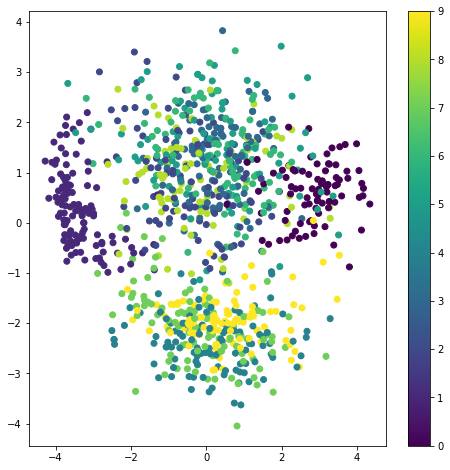

In [40]:
n = len(feature_pred_list)
idx = np.random.choice(list(range(n)), 1000)

fig = plt.figure(figsize=(8,8))
plt.scatter(principalComponents[:,0][idx],principalComponents[:,1][idx], c=label_list[idx])

cb = plt.colorbar()
#loc = np.arange(0,max(label),max(label)/float(len(colors)))
#cb.set_ticks(loc)
#cb.set_ticklabels(colors)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...
[t-SNE] Computed neighbors for 5000 samples in 0.391s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.119877
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.521378
[t-SNE] KL divergence after 1000 iterations: 1.208963


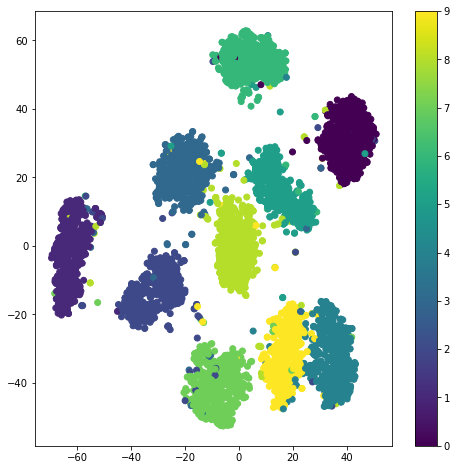

In [44]:
from sklearn.manifold import TSNE
n = len(feature_pred_list)
idx = np.random.choice(list(range(n)), 5000)
X_embedded = TSNE(n_components=2,verbose=1, perplexity=50, n_iter=1000, learning_rate=200
                 ).fit_transform(feature_pred_list.cpu().detach().numpy()[idx])
fig = plt.figure(figsize=(8,8))
plt.scatter(X_embedded[:,0],X_embedded[:,1], c=label_list[idx])

cb = plt.colorbar()

In [8]:
from pathlib import Path
from importlib import reload  
import sys,os
import os.path as osp
sys.path.append(os.path.abspath(os.path.join('IDEC_pytorch/')))
import idec_minibatch as idec_mod
reload(idec_mod)
from idec_minibatch import IDEC
import IDEC_pytorch.utils as utils_idec
reload(utils_idec)


<module 'IDEC_pytorch.utils' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/IDEC_pytorch/utils.py'>

In [9]:
dataset = 'mnist'
n_z=10
alpha=1.0
pretrain_path = 'IDEC_pytorch/data/ae_mnist.pkl'
n_clusters = 10
n_input = 784
batch_size = 256
#from IDEC_pytorch.utils import MnistDataset, cluster_acc
dataset_idec = utils_idec.MnistDataset()

MNIST samples (70000, 784)


In [15]:
from torch.utils.data import DataLoader
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score


num_clusters_dict = {}

#for num_cluster in [4,6,8,9,10,12,14]:
for num_cluster in [10]:
  
    model = IDEC(
        n_enc_1=500,
        n_enc_2=500,
        n_enc_3=1000,
        n_dec_1=1000,
        n_dec_2=500,
        n_dec_3=500,
        n_input=n_input,
        n_z=n_z,
        n_clusters=num_cluster,
        alpha=1.0,
        pretrain_path=pretrain_path
    ).cuda()

    # cluster parameter initiate
    data = dataset_idec.x
    data = torch.Tensor(data).cuda()
    y = dataset_idec.y

    model.load_state_dict(torch.load("IDEC_pytorch/data/ae_mnist_fullmodel_num_clust_{}.pkl".format(num_cluster)))

    latent_pred = []
    true_labels = []
    model.eval()            
    _, tmp_q, z = model(data)
    tmp_q = tmp_q.data
    p = idec_mod.target_distribution(tmp_q)
    # evaluate clustering performance
    y_pred = tmp_q.cpu().numpy().argmax(1) #index (cluster nubmber) of the cluster with the highest probability q.
    acc,reassignment = utils_idec.cluster_acc(y, y_pred)
    nmi = nmi_score(y, y_pred)
    ari = ari_score(y, y_pred)
    print('Acc {:.4f}'.format(acc),
        ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
    latent_pred = z.cpu().detach().numpy()
    true_labels = y
    predicted_reassigned = np.array([reassignment[item] for item in y_pred])
    
    idx = np.random.choice(list(range(latent_pred.shape[0])), 3000)
    num_clusters_dict[num_cluster] = {}
    num_clusters_dict[num_cluster]['sil_score'] = silhouette_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['db_score'] = davies_bouldin_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['ch_score'] = calinski_harabasz_score(latent_pred[idx], predicted_reassigned[idx])


Acc 0.9349 , nmi 0.8871 , ari 0.8722


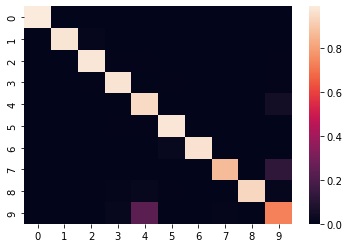

In [24]:
import uuid
confusion = confusion_matrix(y, predicted_reassigned)
normalised_confusion = (
    confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
)
confusion_id = uuid.uuid4().hex
sns.heatmap(normalised_confusion).get_figure().savefig(
     "confusion_%s.png" % confusion_id
)

In [27]:
#Outdated

from torch.utils.data import DataLoader

if 1 > 0:
    model = IDEC(
        n_enc_1=500,
        n_enc_2=500,
        n_enc_3=1000,
        n_dec_1=1000,
        n_dec_2=500,
        n_dec_3=500,
        n_input=n_input,
        n_z=n_z,
        n_clusters=n_clusters,
        alpha=1.0,
        pretrain_path=pretrain_path).cuda()

    #model.pretrain('IDEC_pytorch/data/ae_mnist.pkl')

    train_loader = DataLoader(dataset_idec, batch_size=batch_size, shuffle=False) 

    # cluster parameter initiate
    data = dataset_idec.x
    y = dataset_idec.y
    model.load_state_dict(torch.load("IDEC_pytorch/data/ae_mnist_fullmodel.pkl"))

    feature_pred_list = []
    label_list = []
    pred_label_list=[]
    model.eval()
    for batch_idx, (x, label, idx) in enumerate(train_loader):
        x = x.cuda()
        idx = idx.cuda()
        label = label.cuda()
        _, q, z = model(x)
        feature_pred_list.append(z.detach())
        label_list.append(label.detach())
        pred_label_list.append(q.cpu().detach().numpy().argmax(1))
    feature_pred_list = torch.cat(feature_pred_list)
    label_list = torch.cat(label_list)
    pred_label_list = np.concatenate(pred_label_list)
    
feature_pred_list = feature_pred_list.cpu().detach().numpy()
label_list = label_list.cpu().detach().numpy()

array([9, 4, 0, ..., 8, 9, 5])

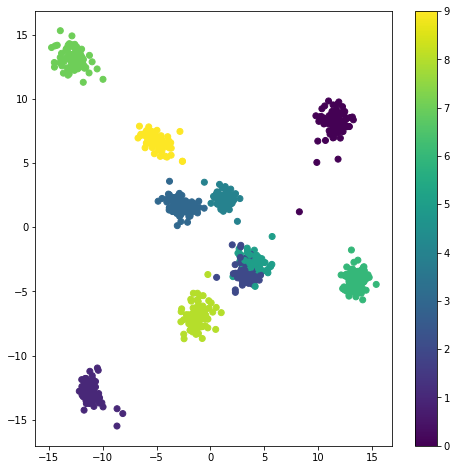

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(latent_pred))


n = len(latent_pred)
idx = np.random.choice(list(range(n)), 1000)

pc1 = principalComponents[:,0][idx]
pc2 = principalComponents[:,1][idx]

fig = plt.figure(figsize=(8,8))
plt.scatter(pc1,pc2, c=predicted_reassigned[idx])

cb = plt.colorbar()

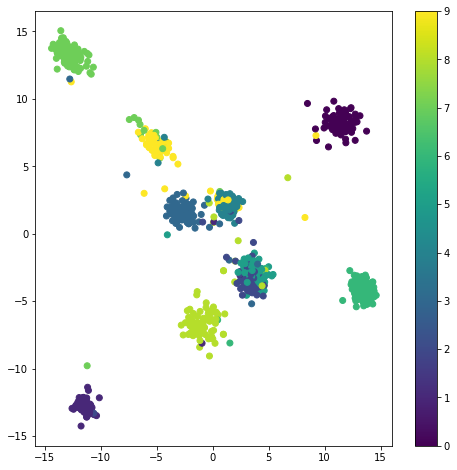

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(latent_pred)


n = len(latent_pred)
idx = np.random.choice(list(range(n)), 1000)

pc1 = principalComponents[:,0][idx]
pc2 = principalComponents[:,1][idx]

fig = plt.figure(figsize=(8,8))
plt.scatter(pc1,pc2, c=true_labels[idx])

cb = plt.colorbar()

In [30]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,verbose=1, perplexity=30, n_iter=1000, learning_rate=200
                 ).fit_transform(latent_pred[idx])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.756511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.228050
[t-SNE] KL divergence after 1000 iterations: 0.418878


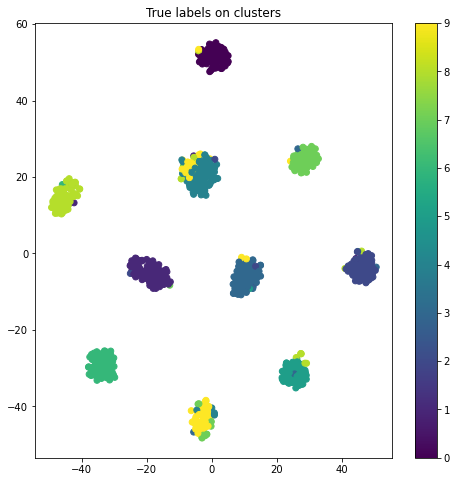

In [31]:

fig = plt.figure(figsize=(8,8))
plt.scatter(X_embedded[:,0],X_embedded[:,1], c=true_labels[idx])
plt.title('True labels on clusters')
cb = plt.colorbar()

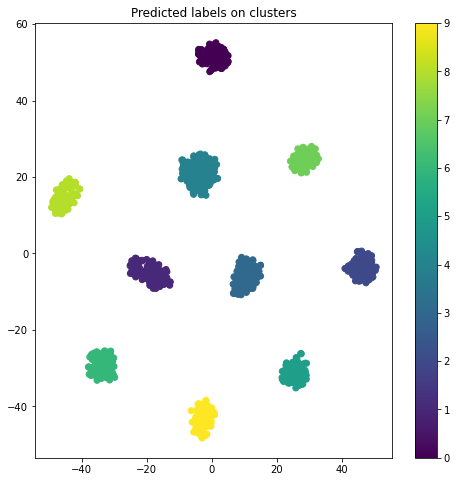

In [32]:

fig = plt.figure(figsize=(8,8))
plt.scatter(X_embedded[:,0],X_embedded[:,1], c=np.array(predicted_reassigned)[idx])
plt.title('Predicted labels on clusters')
cb = plt.colorbar()

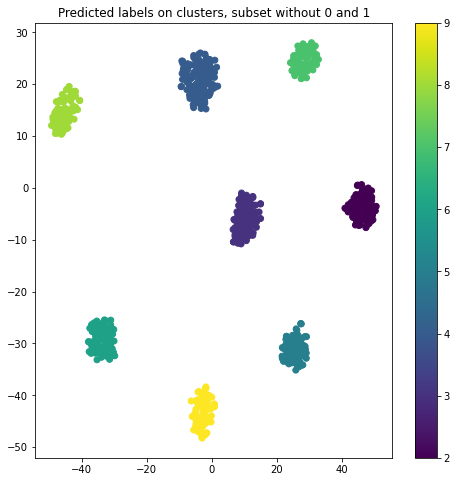

In [33]:
subset_idx = np.where(predicted_reassigned[idx]>1)
fig = plt.figure(figsize=(8,8))
plt.scatter(X_embedded[:,0][subset_idx],X_embedded[:,1][subset_idx], c=np.array(predicted_reassigned)[idx][subset_idx])
plt.title('Predicted labels on clusters, subset without 0 and 1')
cb = plt.colorbar()

In [101]:
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
#The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) 
#and the mean nearest-cluster distance (b) for each sample. 
#The Silhouette Coefficient for a sample is (b - a) / max(a, b). 
#To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. 

In [104]:
#num_clusters_dict = {}
#num_clusters_dict[10] = {}
num_clusters_dict[10]['sil_score'] = silhouette_score(latent_pred[idx], predicted_reassigned[idx])
num_clusters_dict[10]['db_score'] = davies_bouldin_score(latent_pred[idx], predicted_reassigned[idx])
num_clusters_dict[10]['ch_score'] = calinski_harabasz_score(latent_pred[idx], predicted_reassigned[idx])

In [105]:
num_clusters_dict

{10: {'sil_score': 0.800545,
  'db_score': 0.2700435620420346,
  'ch_score': 5799.923637230273}}

0.2700435620420346

In [166]:
plot_metrics = {}
plot_metrics['sil_score'],plot_metrics['db_score'],plot_metrics['ch_score'] = {},{},{}
for num_cluster in [4,6,8,9,10,12,14]:
    plot_metrics['sil_score'][num_cluster] = num_clusters_dict[num_cluster]['sil_score']
    plot_metrics['db_score'][num_cluster] = num_clusters_dict[num_cluster]['db_score']
    plot_metrics['ch_score'][num_cluster] = num_clusters_dict[num_cluster]['ch_score']

In [167]:
import pandas as pd
df_ch_score = pd.DataFrame.from_dict(plot_metrics['ch_score'],orient='index',columns=['ch_score'])
df_sil_score = pd.DataFrame.from_dict(plot_metrics['sil_score'],orient='index',columns=['sil_score'])
df_db_score = pd.DataFrame.from_dict(plot_metrics['db_score'],orient='index',columns=['db_score'])

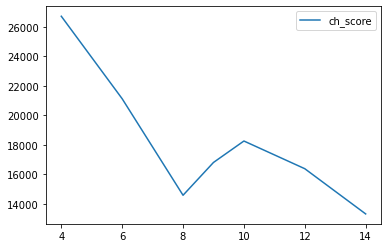

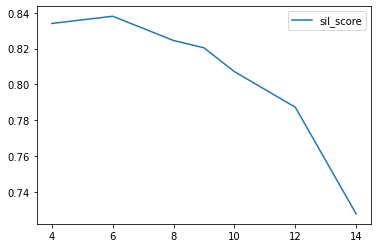

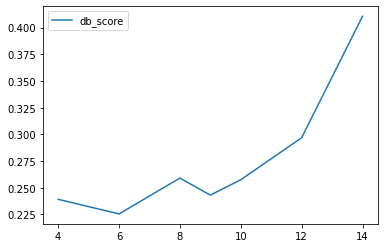

In [168]:
import seaborn as sns
c = sns.lineplot(data=df_ch_score)
plt.show()
c2 =sns.lineplot(data=df_sil_score)
plt.show()
c3 = sns.lineplot(data=df_db_score)


In [9]:
x_gen_output = torch.rand(100,3, 100).cuda()
min_pt_cut = 0.25

In [10]:
non_zeros_dl = (x_gen_output[:,0,:] * x_gen_output[:,0,:] +
                x_gen_output[:,1,:] * x_gen_output[:,1,:] 
                > min_pt_cut**2).cuda()

In [11]:
non_zeros_dl.shape

torch.Size([100, 100])

In [12]:
non_zeros_dl_exp = non_zeros_dl.unsqueeze(1).cuda()

In [13]:
non_zeros_dl_exp.shape

torch.Size([100, 1, 100])

In [15]:
x_gen_output_masked = (non_zeros_dl_exp * x_gen_output)

In [20]:
torch.isnan(x_gen_output_masked).any()

tensor(False, device='cuda:0')